# GAN Based on Monet Paintings

From the Kaggle page “[I’m Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started)”, the goal of this project is to build a GAN that can generate Monet-style images, using landscape photos as input. The competition provides Monet paintings and real photos, and we submit generated Monet-style images for evaluation.

In [20]:
# import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from PIL import Image
import os
from collections import Counter
import random
from tensorflow.keras import layers, models
import zipfile

In [2]:
# set data path to import
monet_path = 'monet_jpg'
photo_path = 'photo_jpg'

# inspect data
def analyze_image_folder(folder_path, folder_name="Dataset"):
    # count number of images
    image_count = 0
    # count all formats
    formats = Counter()
    # count all dimensions
    dimensions = Counter()

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        if os.path.isfile(file_path):
            with Image.open(file_path) as img:
                image_count += 1
                formats[img.format] += 1
                dimensions[img.size] += 1

    print(f"\n--- {folder_name} ---")
    print(f"Total images: {image_count}")
    print(f"File formats: {dict(formats)}")

    unique_dims = list(dimensions.keys())
    print(f"Unique image dimensions: {unique_dims}")


# run analysis
analyze_image_folder(monet_path, "Monet Dataset")
analyze_image_folder(photo_path, "Photo Dataset")



--- Monet Dataset ---
Total images: 300
File formats: {'JPEG': 300}
Unique image dimensions: [(256, 256)]

--- Photo Dataset ---
Total images: 7038
File formats: {'JPEG': 7038}
Unique image dimensions: [(256, 256)]


## Introduction

A Generative Adversarial Network (GAN) is a deep learning framework consisting of two neural networks that compete with each other in a game like setting: a **generator** and a **discriminator**. The generator’s role is to create realistic synthetic images, while the discriminator’s job is to distinguish between real images from the dataset and fake images produced by the generator. Through this adversarial training process, both networks improve simultaneously; the generator learns to produce increasingly realistic outputs, and the discriminator becomes better at detecting subtle differences, until the generated images are difficult to distinguish from real ones.

In this project, the goal is to use a GAN to perform unpaired image to image translation, specifically transforming a real world photograph into a Monet-style painting. Because the dataset does not contain direct photo to Monet pairs of the same scene, the model must learn the general stylistic differences between the two image domains rather than relying on pixel aligned supervision. This setup reflects a realistic and challenging artistic style transfer task.

The dataset consists of two image domains. The Monet dataset contains 300 images, all in JPEG format, with a uniform size of 256 × 256 pixels. The photo dataset contains 7,038 images, also entirely in JPEG format, and likewise standardized to 256 × 256 pixels. This consistent image resolution across both domains simplifies training and eliminates the need for additional resizing during preprocessing, but the large imbalance in dataset sizes maintains a challenge.


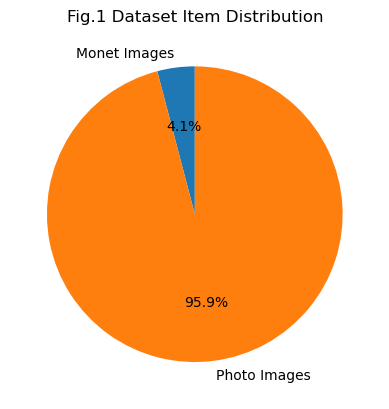

In [3]:
# visualize data make up
labels = ['Monet Images', 'Photo Images']
sizes = [300, 7038]

# Create pie chart
plt.figure()
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Fig.1 Dataset Item Distribution')
plt.show()

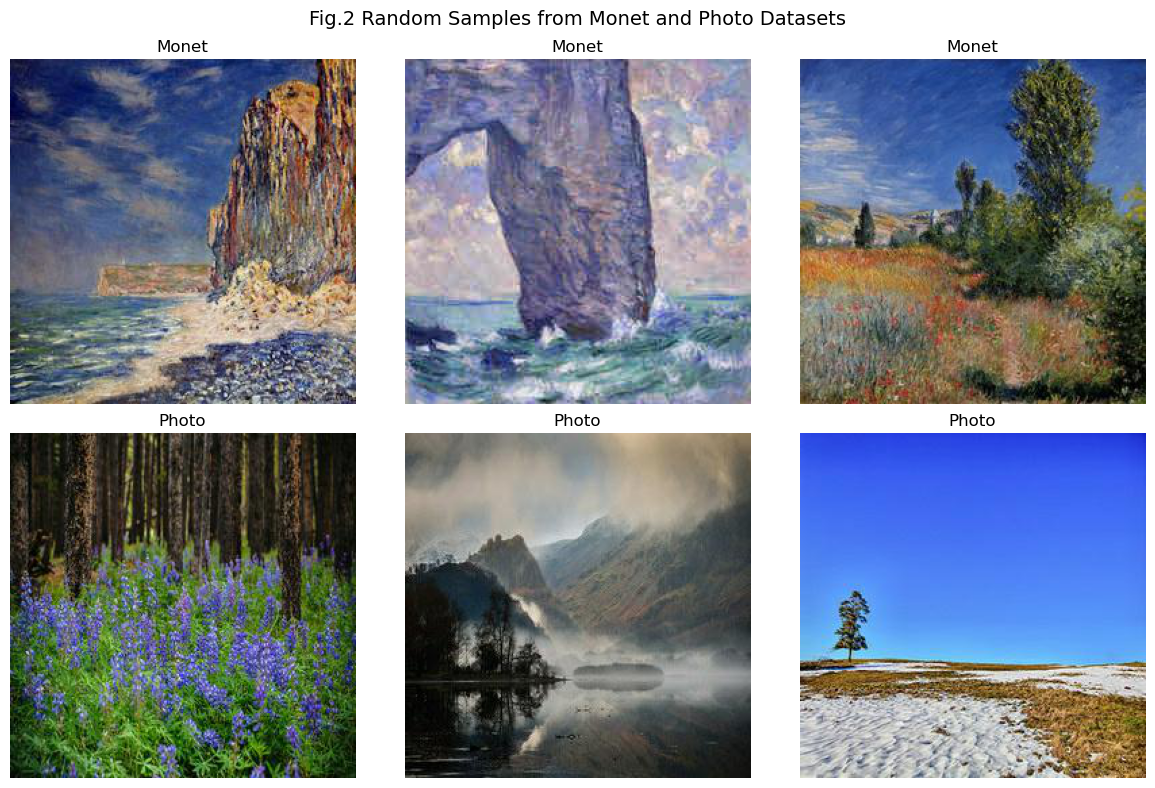

In [ ]:
# select 3 random images from each folder
random.seed(20)
monet_samples = random.sample(os.listdir(monet_path), 3)
photo_samples = random.sample(os.listdir(photo_path), 3)

# create subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# monet images
for i, fname in enumerate(monet_samples):
    img = Image.open(os.path.join(monet_path, fname))
    axes[0, i].imshow(img)
    axes[0, i].set_title("Monet")
    axes[0, i].axis('off')

# photo images
for i, fname in enumerate(photo_samples):
    img = Image.open(os.path.join(photo_path, fname))
    axes[1, i].imshow(img)
    axes[1, i].set_title("Photo")
    axes[1, i].axis('off')

# Figure title
plt.suptitle("Fig.2 Random Samples from Monet and Photo Datasets", fontsize=14)
plt.tight_layout()
plt.show()

### Color Palette Differences

The Monet paintings exhibit a distinctly stylized color palette characterized by pastel tones, soft gradients, and harmonized color themes. Blues, purples, soft greens, and warm yellows dominate the scenes, often blended smoothly to convey atmosphere rather than precise realism. The colors are emotionally expressive rather than physically accurate, and strong, visible brush strokes give the colors a layered, dynamic appearance. In contrast, the real photographs display more varied, saturated, and physically realistic colors. The blues of the sky, the greens of vegetation, and the whites of snow appear more precise and scene-dependent, reflecting natural lighting conditions and environmental detail rather than artistic interpretation.

### Texture and Detail Differences

There is also a clear contrast in texture and surface detail between the two domains. The Monet images show pronounced painterly textures, with visible brush strokes, soft edges, and abstracted shapes. Fine details are often implied rather than explicitly defined, contributing to the impressionistic style. On the other hand, the photographs contain sharp edges, high frequency details, and crisp textures, such as individual tree branches, flower petals, reflections on water, and grain in snow or soil. These photographic textures result from real world lighting and camera sensor capture, making them significantly more detailed and structurally precise than the painted images.



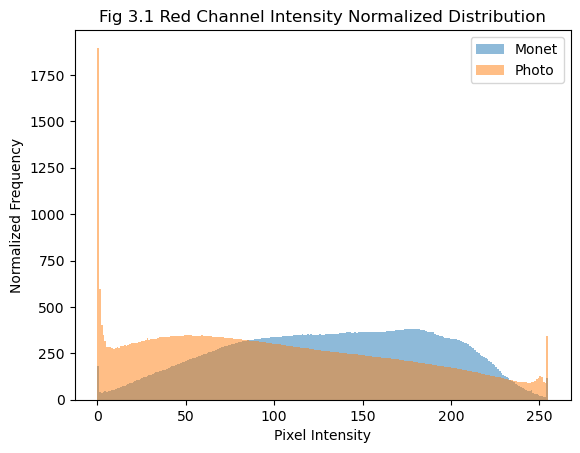

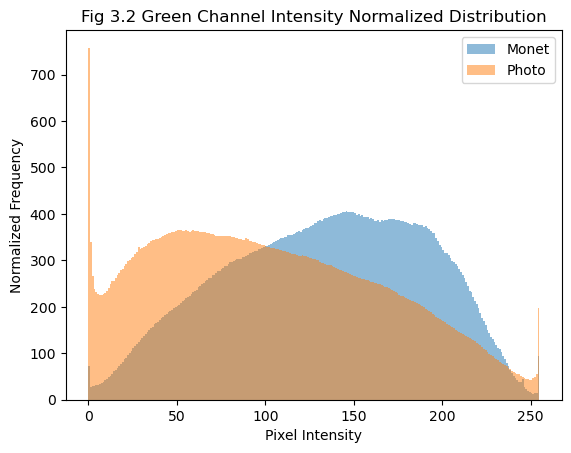

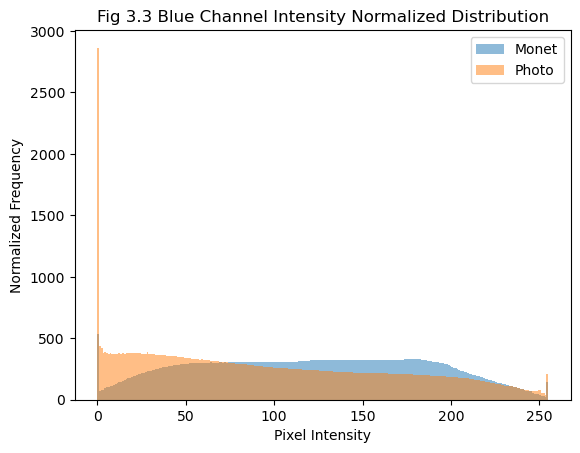

In [ ]:
# inspect rgb intensity distribution
def load_pixels_and_count(folder):
    pixels = []
    files = os.listdir(folder)
    num_images = len(files)

    for fname in files:
        img = Image.open(os.path.join(folder, fname)).convert('RGB')
        pixels.append(np.array(img).reshape(-1, 3))

    return np.vstack(pixels), num_images

# load pixel data and image counts
monet_pixels, monet_count = load_pixels_and_count(monet_path)
photo_pixels, photo_count = load_pixels_and_count(photo_path)

# red channel histogram
plt.figure()
plt.hist(monet_pixels[:, 0], bins=256, alpha=0.5,
         weights=np.ones(len(monet_pixels)) / monet_count,
         label="Monet")
plt.hist(photo_pixels[:, 0], bins=256, alpha=0.5,
         weights=np.ones(len(photo_pixels)) / photo_count,
         label="Photo")
plt.legend()
plt.title("Fig 3.1 Red Channel Intensity Normalized Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Normalized Frequency")
plt.show()

# green channel histogram
plt.figure()
plt.hist(monet_pixels[:, 1], bins=256, alpha=0.5,
         weights=np.ones(len(monet_pixels)) / monet_count,
         label="Monet")
plt.hist(photo_pixels[:, 1], bins=256, alpha=0.5,
         weights=np.ones(len(photo_pixels)) / photo_count,
         label="Photo")
plt.legend()
plt.title("Fig 3.2 Green Channel Intensity Normalized Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Normalized Frequency")
plt.show()

# blue channel histogram
plt.figure()
plt.hist(monet_pixels[:, 2], bins=256, alpha=0.5,
         weights=np.ones(len(monet_pixels)) / monet_count,
         label="Monet")
plt.hist(photo_pixels[:, 2], bins=256, alpha=0.5,
         weights=np.ones(len(photo_pixels)) / photo_count,
         label="Photo")
plt.legend()
plt.title("Fig 3.3 Blue Channel Intensity Normalized Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Normalized Frequency")
plt.show()


The pixel intensity histograms for the red, green, and blue channels were normalized by dividing the contribution of each pixel by the total number of images in each dataset, rather than by the total number of pixels. This normalization ensures that the distributions represent the average per-image color usage rather than being dominated by the much larger photo dataset. As a result, the observed differences between the Monet and photo distributions reflect true stylistic differences in color composition, not dataset size imbalance. The Monet images exhibit more concentrated, smoother intensity distributions consistent with painterly color blending, while the photographs show broader, more irregular distributions caused by natural lighting variability, shadows, and high-frequency texture detail.


In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
# cyclegan is usually trained with batch size 1
BATCH_SIZE = 1
# cycle consistency weight
LAMBDA_CYCLE = 10.0
# identity loss weight
LAMBDA_ID = 5.0
AUTOTUNE = tf.data.AUTOTUNE

# load data
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = (img * 2.0) - 1.0
    return img

# create a dataset of data
def make_dataset(folder):
    files = tf.data.Dataset.list_files(os.path.join(folder, "*.jpg"), shuffle=True)
    ds = files.map(load_image, num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

monet_ds = make_dataset(monet_path)
photo_ds = make_dataset(photo_path)


## Model Architecture


This project utilizes a Cycle Consistent GAN to perform unpaired image to image translation between real world photographs and Monet style paintings. Unlike traditional supervised style transfer approaches that require paired training images, CycleGAN is specifically designed to learn mappings between two visual domains without paired correspondence, which matches the structure of the provided dataset. CycleGAN overcomes this limitation by introducing cycle consistency constraints, allowing the model to learn meaningful bidirectional transformations using only unpaired data.

The CycleGAN framework consists of:

* Two **generators** that learn mappings between domains:

  * $ G: \text{Photo} \rightarrow \text{Monet} $
  * $ F: \text{Monet} \rightarrow \text{Photo} $
* Two **discriminators** that judge realism in each domain:

  * ( D_{\text{Monet}} ) distinguishes real Monet paintings from generated Monet-style images.
  * ( D_{\text{Photo}} ) distinguishes real photographs from generated photographs.

Although the Kaggle evaluation only requires generating Monet-style images from real photos using a single generator, the model is trained using the full CycleGAN framework with two generators and two discriminators because the dataset is unpaired. The second generator and discriminator enable the use of cycle-consistency and identity constraints, which stabilize training and preserve image content while learning a meaningful photo to Monet style transformation when run adversarially. 

The generator follows an encoder–transformer–decoder architecture. The input image of size 256 × 256 × 3 is first processed by an encoding stage consisting of a 7×7 convolutional layer with 64 filters, followed by two strided convolutional layers with 128 and 256 filters to progressively downsample the image. Batch normalization and ReLU activations are applied after each convolution to stabilize training and introduce non-linearity. The resulting compressed feature representation is then passed through six ResNet residual blocks, each composed of two 3×3 convolution layers with batch normalization, ReLU activation, and a skip connection. These residual connections allow the network to preserve the structural content of the original image while primarily modifying texture, color distribution, and brush-like patterns characteristic of Monet-style paintings, and they also help mitigate vanishing gradient issues during deep network training. Finally, the transformed features are decoded back to image space using two transposed convolutional layers with 128 and 64 filters, followed by a final 7×7 convolution layer with three output channels and a tanh activation function that maps pixel values to the normalized range of [−1, 1], consistent with the preprocessing applied during training. The tanh activation function was used as it produces data that is centered at zero, which is useful for efficient CNN training.

Each discriminator follows a 70×70 PatchGAN architecture which classifies overlapping image patches as real or fake rather than making a single global decision. It is composed of a series of 4×4 convolutional layers with increasing filter sizes (64, 128, 256, 512), strided downsampling, and LeakyReLU activations, followed by a final 1-channel convolution that outputs a grid of authenticity predictions. By operating at the patch level, the discriminator emphasizes local texture realism encouraging accurate brush stroke patterns, smooth color transitions, and consistent fine-scale structure in the generated Monet-style images.


In [9]:
def conv7s1(x, filters):
    # 7x7 convolution
    init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=20)
    x = layers.Conv2D(filters, 7, strides=1, padding="same",
                      kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def downsample(x, filters):
    # strided convolution (downsampling)
    init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=20)
    x = layers.Conv2D(filters, 3, strides=2, padding="same",
                      kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def upsample(x, filters):
    # transposed convolution
    init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=20)
    x = layers.Conv2DTranspose(filters, 3, strides=2, padding="same",
                               kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def residual_block(x, filters):
    # resnet residual block
    init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=20)

    y = layers.Conv2D(filters, 3, padding="same",
                      kernel_initializer=init, use_bias=False)(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation("relu")(y)

    y = layers.Conv2D(filters, 3, padding="same",
                      kernel_initializer=init, use_bias=False)(y)
    y = layers.BatchNormalization()(y)

    return layers.Add()([x, y])

def build_generator(name=None):
    # full size rgb input
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # Encoding (downsampling)
    x = conv7s1(inputs, 64)
    x = downsample(x, 128)
    x = downsample(x, 256)

    # 6 resnet blocks
    for _ in range(6):     
        x = residual_block(x, 256)

    # decoding (upsampling)
    x = upsample(x, 128)
    x = upsample(x, 64)

    # output layer using tanh -> [-1, 1]
    init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=20)
    x = layers.Conv2D(3, 7, strides=1, padding="same",
                      kernel_initializer=init)(x)
    outputs = layers.Activation("tanh")(x)

    return tf.keras.Model(inputs, outputs, name=name)


# photo -> monet generator
G_photo2monet = build_generator("G_photo2monet")

# monet -> photo generator
G_monet2photo = build_generator("G_monet2photo")


In [10]:
def disc_block(x, filters, stride, use_norm=True):
    # patchgan convolutional block
    init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=20)

    x = layers.Conv2D(filters, 4, strides=stride, padding="same",
                      kernel_initializer=init, use_bias=not use_norm)(x)

    if use_norm:
        x = layers.BatchNormalization()(x)

    x = layers.LeakyReLU(0.2)(x)
    return x

def build_discriminator(name=None):
    # full size input
    inp = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # progressive downsampling
    x = disc_block(inp, 64, 2, use_norm=False)
    x = disc_block(x, 128, 2)
    x = disc_block(x, 256, 2)
    x = disc_block(x, 512, 1)

    # final patchgan output
    init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=20)
    x = layers.Conv2D(1, 4, strides=1, padding="same",
                      kernel_initializer=init)(x)

    return tf.keras.Model(inp, x, name=name)


# monet discriminator
D_monet = build_discriminator("D_monet")

# photo discriminator
D_photo = build_discriminator("D_photo")


The total CycleGAN training objective is defined as a weighted combination of three primary loss components. First, an adversarial loss based on the Least-Squares GAN (LSGAN) formulation is used to provide smoother gradients and more stable training compared to standard binary cross-entropy, encouraging each generator to produce images that its corresponding discriminator classifies as real. Second, a cycle-consistency loss enforces that mapping a photo to Monet and back to photo, and likewise mapping a Monet painting to photo and back to Monet, reconstructs the original image. This constraint is computed using an L1 distance and weighted by a cycle coefficient $\lambda = 10$, ensuring that structural content is preserved during translation. Third, an identity loss also based on L1 distance and weighted by $\lambda_{\text{id}} = 5$, discourages unnecessary color or tone shifts when an image is already in the target domain. Each generator minimizes a weighted sum of these three losses, while each discriminator is trained to minimize the adversarial classification loss for distinguishing real images from generated samples.


In [11]:
# least-squares GAN loss
loss_obj = tf.keras.losses.MeanSquaredError()

# generator wants discriminator to classify fake images as real (1).
def generator_adv_loss(fake_logits):
    return loss_obj(tf.ones_like(fake_logits), fake_logits)

# discriminator wants the opposite
def discriminator_loss(real_logits, fake_logits):
    real_loss = loss_obj(tf.ones_like(real_logits), real_logits)
    fake_loss = loss_obj(tf.zeros_like(fake_logits), fake_logits)
    return 0.5 * (real_loss + fake_loss)

def cycle_loss(real, cycled):
    return tf.reduce_mean(tf.abs(real - cycled)) * LAMBDA_CYCLE

def identity_loss(real, same):
    return tf.reduce_mean(tf.abs(real - same)) * LAMBDA_ID

# optimizers for generators and discriminators
G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
F_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
D_monet_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
D_photo_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [12]:
@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:
        # forward cycle: photo -> monet -> photo
        fake_monet = G_photo2monet(real_photo, training=True)
        cycled_photo = G_monet2photo(fake_monet, training=True)

        # backward cycle: monet -> photo -> monet
        fake_photo = G_monet2photo(real_monet, training=True)
        cycled_monet = G_photo2monet(fake_photo, training=True)

        # identity
        same_monet = G_photo2monet(real_monet, training=True)
        same_photo = G_monet2photo(real_photo, training=True)

        # discriminator outputs
        disc_real_monet = D_monet(real_monet, training=True)
        disc_fake_monet = D_monet(fake_monet, training=True)

        disc_real_photo = D_photo(real_photo, training=True)
        disc_fake_photo = D_photo(fake_photo, training=True)

        # generator adversarial losses
        G_loss_adv = generator_adv_loss(disc_fake_monet)
        F_loss_adv = generator_adv_loss(disc_fake_photo)

        # cycle consistency loss
        total_cycle_loss = cycle_loss(real_monet, cycled_monet) + \
                           cycle_loss(real_photo, cycled_photo)

        # identity losses
        G_id_loss = identity_loss(real_monet, same_monet)
        F_id_loss = identity_loss(real_photo, same_photo)

        # total generator losses
        G_total_loss = G_loss_adv + total_cycle_loss + G_id_loss
        F_total_loss = F_loss_adv + total_cycle_loss + F_id_loss

        # discriminator losses
        D_monet_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        D_photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

    # gradients
    G_grads = tape.gradient(G_total_loss, G_photo2monet.trainable_variables)
    F_grads = tape.gradient(F_total_loss, G_monet2photo.trainable_variables)
    D_monet_grads = tape.gradient(D_monet_loss, D_monet.trainable_variables)
    D_photo_grads = tape.gradient(D_photo_loss, D_photo.trainable_variables)

    # apply gradients
    G_optimizer.apply_gradients(zip(G_grads, G_photo2monet.trainable_variables))
    F_optimizer.apply_gradients(zip(F_grads, G_monet2photo.trainable_variables))
    D_monet_optimizer.apply_gradients(zip(D_monet_grads, D_monet.trainable_variables))
    D_photo_optimizer.apply_gradients(zip(D_photo_grads, D_photo.trainable_variables))

    return {
        "G_total": G_total_loss,
        "F_total": F_total_loss,
        "D_monet": D_monet_loss,
        "D_photo": D_photo_loss,
    }


In [13]:
# Checkpointing
ckpt = tf.train.Checkpoint(
    G_photo2monet=G_photo2monet,
    G_monet2photo=G_monet2photo,
    D_monet=D_monet,
    D_photo=D_photo,
    G_optimizer=G_optimizer,
    F_optimizer=F_optimizer,
    D_monet_optimizer=D_monet_optimizer,
    D_photo_optimizer=D_photo_optimizer,
)
ckpt_manager = tf.train.CheckpointManager(ckpt, "./checkpoints", max_to_keep=5)

# Restore last checkpoint if exists
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Restored from", ckpt_manager.latest_checkpoint)
else:
    print("Initializing from scratch.")

# Make infinite iterators over datasets
monet_iter = iter(monet_ds.repeat())
photo_iter = iter(photo_ds.repeat())

EPOCHS = 10               # you can increase when things are working
STEPS_PER_EPOCH = 1000    # or tune based on runtime

for epoch in range(1, EPOCHS + 1):
    for step in range(1, STEPS_PER_EPOCH + 1):
        real_monet = next(monet_iter)
        real_photo = next(photo_iter)

        losses = train_step(real_monet, real_photo)

        if step % 100 == 0:
            print(
                f"Epoch {epoch} Step {step}: "
                f"G={losses['G_total']:.3f}, "
                f"F={losses['F_total']:.3f}, "
                f"Dm={losses['D_monet']:.3f}, "
                f"Dp={losses['D_photo']:.3f}"
            )

    # Save checkpoint every epoch
    ckpt_save_path = ckpt_manager.save()
    print(f"Checkpoint saved at {ckpt_save_path}")


Initializing from scratch.
Epoch 1 Step 100: G=6.363, F=6.725, Dm=0.277, Dp=0.350
Epoch 1 Step 200: G=6.933, F=7.769, Dm=0.245, Dp=0.311
Epoch 1 Step 300: G=5.068, F=5.029, Dm=0.218, Dp=0.354
Epoch 1 Step 400: G=6.702, F=7.131, Dm=0.277, Dp=0.309
Epoch 1 Step 500: G=6.074, F=6.062, Dm=0.314, Dp=0.355
Epoch 1 Step 600: G=7.140, F=6.903, Dm=0.222, Dp=0.347
Epoch 1 Step 700: G=6.766, F=7.561, Dm=0.202, Dp=0.204
Epoch 1 Step 800: G=5.092, F=5.534, Dm=0.208, Dp=0.196
Epoch 1 Step 900: G=6.251, F=6.389, Dm=0.205, Dp=0.225
Epoch 1 Step 1000: G=5.211, F=5.169, Dm=0.227, Dp=0.387
Checkpoint saved at ./checkpoints\ckpt-1
Epoch 2 Step 100: G=5.580, F=5.819, Dm=0.231, Dp=0.237
Epoch 2 Step 200: G=5.449, F=5.390, Dm=0.267, Dp=0.235
Epoch 2 Step 300: G=6.188, F=6.396, Dm=0.285, Dp=0.148
Epoch 2 Step 400: G=7.196, F=7.279, Dm=0.092, Dp=0.160
Epoch 2 Step 500: G=8.493, F=7.862, Dm=0.262, Dp=0.203
Epoch 2 Step 600: G=4.616, F=4.644, Dm=0.242, Dp=0.319
Epoch 2 Step 700: G=5.762, F=6.854, Dm=0.106, Dp=0.

In [16]:
def upload_image(tensor):
    """
    Converts generator output from [-1,1] back to uint8 [0,255]
    """
    img = (tensor + 1.0) / 2.0  # [0,1]
    img = tf.clip_by_value(img, 0.0, 1.0)
    img = tf.image.convert_image_dtype(img, tf.uint8)
    return img

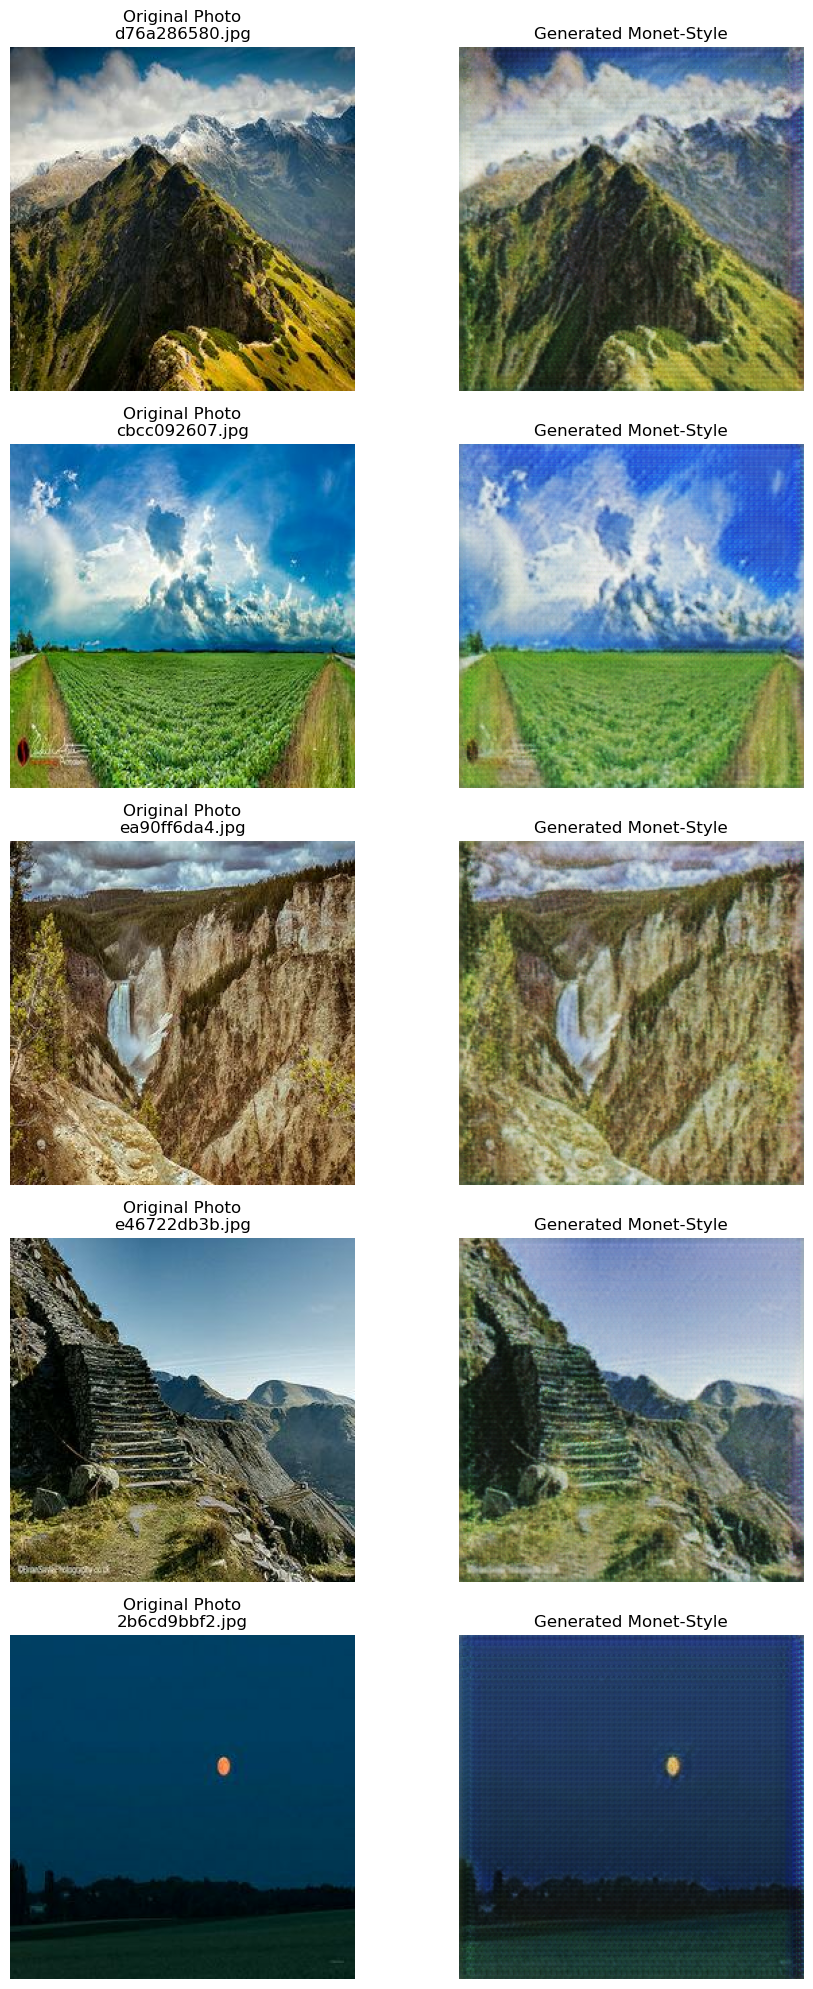

In [17]:
random.seed(20)
tf.random.set_seed(20)

# Select 5 random photo filenames
photo_files = sorted(os.listdir(photo_path))
sample_files = random.sample(photo_files, 5)

plt.figure(figsize=(10, 20))

for i, fname in enumerate(sample_files):
    # Load and preprocess input photo
    in_path = os.path.join(photo_path, fname)
    img = load_image(in_path)
    img_batch = tf.expand_dims(img, axis=0)

    # Generate Monet-style image
    fake_monet = G_photo2monet(img_batch, training=False)
    fake_monet = tf.squeeze(fake_monet, axis=0)
    fake_monet = upload_image(fake_monet)

    # Convert tensors for plotting
    orig = ((img + 1.0) / 2.0).numpy()
    fake = fake_monet.numpy() / 255.0

    # Plot original photo (left)
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(orig)
    plt.title(f"Original Photo\n{fname}")
    plt.axis("off")

    # Plot generated Monet-style image (right)
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(fake)
    plt.title("Generated Monet-Style")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [19]:
OUTPUT_DIR = "images"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# (Optional) restore latest checkpoint if you use checkpoints
# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print("Restored from", ckpt_manager.latest_checkpoint)

photo_files = sorted(os.listdir(photo_path))

# Limit to 10,000 images just to be safe with competition rule
photo_files = photo_files[:10000]

for i, fname in enumerate(photo_files):
    in_path = os.path.join(photo_path, fname)

    # Preprocess input photo
    img = load_image(in_path)
    img_batch = tf.expand_dims(img, axis=0)

    # Generate Monet-style image
    fake_monet = G_photo2monet(img_batch, training=False)
    fake_monet = tf.squeeze(fake_monet, axis=0)
    fake_monet = upload_image(fake_monet)

    # Encode and save as JPEG
    out_path = os.path.join(OUTPUT_DIR, fname)  # keep same filename
    encoded = tf.image.encode_jpeg(fake_monet)
    tf.io.write_file(out_path, encoded)

    if (i + 1) % 500 == 0:
        print(f"Saved {i+1} / {len(photo_files)} images")

print("All Monet-style images saved in:", OUTPUT_DIR)


Saved 500 / 7038 images
Saved 1000 / 7038 images
Saved 1500 / 7038 images
Saved 2000 / 7038 images
Saved 2500 / 7038 images
Saved 3000 / 7038 images
Saved 3500 / 7038 images
Saved 4000 / 7038 images
Saved 4500 / 7038 images
Saved 5000 / 7038 images
Saved 5500 / 7038 images
Saved 6000 / 7038 images
Saved 6500 / 7038 images
Saved 7000 / 7038 images
All Monet-style images saved in: images


In [21]:
ZIP_FILENAME = "images.zip"

with zipfile.ZipFile(ZIP_FILENAME, "w", zipfile.ZIP_DEFLATED) as zf:
    for fname in sorted(os.listdir(OUTPUT_DIR)):
        if fname.lower().endswith(".jpg") or fname.lower().endswith(".jpeg"):
            full_path = os.path.join(OUTPUT_DIR, fname)
            # store only filename (no folder path) inside the zip
            zf.write(full_path, arcname=fname)

print("Created zip file:", ZIP_FILENAME)


Created zip file: images.zip
